# 🎯 Tercer Trabajo Práctico - Análisis Estadístico Final

**Curso:** Probabilidad y Estadística para la Inteligencia Artificial  
**Estudiante:** Eliana Harriet  
**Código SIU:** a2217  
**Docente:** Camilo Argoty  
**Institución:** CEIA - Universidad de Buenos Aires

---

## 📖 Contexto del Problema

Don Francisco, gracias a los análisis previos de Matías, ahora cuenta con **5 supermercados**:
- 'Santa Ana'
- 'La Floresta' 
- 'Los Cedros'
- 'Palermo'
- 'Córdoba'

### 🔍 Objetivos del Análisis

1. **Intervalos de Confianza:** Analizar ventas mensuales del supermercado 'Santa Ana'
2. **Análisis ANOVA:** Determinar si las ventas son iguales entre todos los supermercados
3. **Comparación de Extremos:** Identificar y comparar las tiendas con mayor y menor promedio de ventas

---


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

print(f"📊 Pandas versión: {pd.__version__}")
print(f"🔢 NumPy versión: {np.__version__}")


📊 Pandas versión: 2.3.1
🔢 NumPy versión: 2.3.1


In [15]:
print("🔍 CARGANDO DATOS...")
print("=" * 50)

try:
    excel_file = pd.ExcelFile('../data/Datos_TP_final_22Co2025_a2217.xlsx')
    print("📋 HOJAS DISPONIBLES EN EL EXCEL:")
    supermercados = excel_file.sheet_names
    for i, sheet_name in enumerate(supermercados, 1):
        print(f"{i:2d}. {sheet_name}")
    
    datos_consolidados = []
    
    for supermercado in supermercados:
        df_temp = pd.read_excel('../data/Datos_TP_final_22Co2025_a2217.xlsx', sheet_name=supermercado)
        df_temp = df_temp.rename(columns={'Fecha': 'fecha', 'Ventas': 'ventas'})
        df_temp['supermercado'] = supermercado
        df_temp = df_temp[['fecha', 'ventas', 'supermercado']]
        datos_consolidados.append(df_temp)
        print(f"✅ Cargado: {supermercado} - {df_temp.shape[0]} registros")
    
    df = pd.concat(datos_consolidados, ignore_index=True)
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    print(f"\n📏 Dataset consolidado: {df.shape}")
    print("📋 Columnas: fecha, ventas, supermercado")
    
except FileNotFoundError:
    print("❌ Error: No se encontró el archivo de datos")
    print("📁 Verificar que el archivo esté en: trabajo3/data/Datos_TP_final_22Co2025_a2217.xlsx")


🔍 CARGANDO DATOS...
📋 HOJAS DISPONIBLES EN EL EXCEL:
 1. Santa Ana
 2. La Floresta
 3. Los Cedros
 4. Palermo
 5. Córdoba
✅ Cargado: Santa Ana - 365 registros
✅ Cargado: La Floresta - 365 registros
✅ Cargado: Los Cedros - 365 registros
✅ Cargado: Palermo - 365 registros
✅ Cargado: Córdoba - 365 registros

📏 Dataset consolidado: (1825, 3)
📋 Columnas: fecha, ventas, supermercado


In [16]:
print("🔍 INFORMACIÓN GENERAL DEL DATASET CONSOLIDADO")
print("=" * 60)
df.info()

print("\n📊 PRIMERAS 5 FILAS:")
print("=" * 30)
display(df.head())

print(f"\n🔢 Total de supermercados: {len(df['supermercado'].unique())}")
print(f"📏 Total de registros: {len(df)}")

print("\n📈 ESTADÍSTICAS DESCRIPTIVAS POR SUPERMERCADO")
print("=" * 60)
estadisticas_por_super = df.groupby('supermercado')['ventas'].describe().round(2)
display(estadisticas_por_super)


🔍 INFORMACIÓN GENERAL DEL DATASET CONSOLIDADO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha         1825 non-null   datetime64[ns]
 1   ventas        1825 non-null   float64       
 2   supermercado  1825 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.9+ KB

📊 PRIMERAS 5 FILAS:


,fecha,ventas,supermercado
0,2023-01-01,12918.480638,Santa Ana
1,2023-01-02,11699.318441,Santa Ana
2,2023-01-03,13608.319914,Santa Ana
3,2023-01-04,15944.067736,Santa Ana
4,2023-01-05,19735.984815,Santa Ana



🔢 Total de supermercados: 5
📏 Total de registros: 1825

📈 ESTADÍSTICAS DESCRIPTIVAS POR SUPERMERCADO


,count,mean,std,min,25%,50%,75%,max
supermercado,,,,,,,,
Córdoba,365.0,17837.21,3014.50,9128.51,15937.98,17959.66,19980.26,25298.44
La Floresta,365.0,21839.77,2963.63,13933.92,19803.81,22160.34,24156.92,30455.06
Los Cedros,365.0,18903.12,3034.57,9175.07,17152.46,18796.61,21167.91,26487.29
Palermo,365.0,19752.32,2922.15,10712.42,17705.37,19741.92,21902.09,27916.14
Santa Ana,365.0,19170.38,2959.34,11526.82,17198.53,19166.11,21342.12,27199.59


In [17]:
# EJERCICIO 1: Intervalos de Confianza Empíricos para Santa Ana
import calendar

print("🎯 EJERCICIO 1: INTERVALOS DE CONFIANZA EMPÍRICOS")
print("=" * 60)
print("📋 Objetivo: Calcular IC empíricos para 'Santa Ana' por mes (95% y 99%)")

df_santa_ana = df[df['supermercado'] == 'Santa Ana'][['fecha', 'ventas', 'supermercado']].copy()
print(f"✅ Datos de Santa Ana: {len(df_santa_ana)} registros")

ventas_por_mes_santa_ana = df_santa_ana.groupby(df_santa_ana['fecha'].dt.month)['ventas'].apply(list).to_dict()

print("\n📊 RESUMEN DE DATOS POR MES - SANTA ANA:")
print("=" * 50)
for mes_num in sorted(ventas_por_mes_santa_ana.keys()):
    ventas = ventas_por_mes_santa_ana[mes_num]
    n_dias = len(ventas)
    promedio = np.mean(ventas)
    std = np.std(ventas, ddof=1)
    print(f"{calendar.month_name[mes_num]:<10}: {n_dias:2d} días, Promedio: ${promedio:8.2f}, Std: ${std:6.2f}")

print("\n🔢 CALCULANDO INTERVALOS DE CONFIANZA...")
print("=" * 50)

# Definición de la función de IC (bootstrap)
def calcular_intervalo_confianza_empirico(data, confidence_level=0.95):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n_bootstrap = 10000
    rng = np.random.default_rng(42)
    bootstrap_means = rng.choice(data, size=(n_bootstrap, n), replace=True).mean(axis=1)
    alpha = 1 - confidence_level
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    return {
        'mean': mean,
        'std': std,
        'n': n,
        'confidence_level': confidence_level,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'margin_error': (ci_upper - ci_lower) / 2
    }

# Calcular IC por mes
resultados_ic_95 = {}
resultados_ic_99 = {}

for mes_num in sorted(ventas_por_mes_santa_ana.keys()):
    ventas = ventas_por_mes_santa_ana[mes_num]
    resultados_ic_95[mes_num] = calcular_intervalo_confianza_empirico(ventas, confidence_level=0.95)
    resultados_ic_99[mes_num] = calcular_intervalo_confianza_empirico(ventas, confidence_level=0.99)

meses_ordenados = sorted(ventas_por_mes_santa_ana.keys())
resultados_df = pd.DataFrame({
    'Mes': [calendar.month_name[m] for m in meses_ordenados],
    'IC_95_Inferior': [resultados_ic_95[m]['ci_lower'] for m in meses_ordenados],
    'IC_95_Superior': [resultados_ic_95[m]['ci_upper'] for m in meses_ordenados],
    'IC_99_Inferior': [resultados_ic_99[m]['ci_lower'] for m in meses_ordenados],
    'IC_99_Superior': [resultados_ic_99[m]['ci_upper'] for m in meses_ordenados]
})

print("\n📊 INTERVALOS DE CONFIANZA - SANTA ANA:")
print("=" * 50)
print(resultados_df)


🎯 EJERCICIO 1: INTERVALOS DE CONFIANZA EMPÍRICOS
📋 Objetivo: Calcular IC empíricos para 'Santa Ana' por mes (95% y 99%)
✅ Datos de Santa Ana: 365 registros

📊 RESUMEN DE DATOS POR MES - SANTA ANA:
January   : 31 días, Promedio: $15327.83, Std: $2371.06
February  : 28 días, Promedio: $17091.14, Std: $2195.57
March     : 31 días, Promedio: $19786.16, Std: $2144.87
April     : 30 días, Promedio: $18385.11, Std: $2898.98
May       : 31 días, Promedio: $19876.80, Std: $2699.34
June      : 30 días, Promedio: $20616.13, Std: $2112.39
July      : 31 días, Promedio: $19115.00, Std: $2546.54
August    : 31 días, Promedio: $20374.11, Std: $3228.21
September : 30 días, Promedio: $20369.65, Std: $2566.90
October   : 31 días, Promedio: $20277.96, Std: $2915.32
November  : 30 días, Promedio: $19917.69, Std: $2855.39
December  : 31 días, Promedio: $18789.89, Std: $2120.95

🔢 CALCULANDO INTERVALOS DE CONFIANZA...

📊 INTERVALOS DE CONFIANZA - SANTA ANA:
          Mes  IC_95_Inferior  IC_95_Superior  IC_

📊 VISUALIZACIÓN DE INTERVALOS DE CONFIANZA - SANTA ANA
📋 TABLA RESUMEN - INTERVALOS DE CONFIANZA SANTA ANA:
Mes          Media      IC 95%                      IC 99%                     
--------------------------------------------------------------------------------
Jan          $15327.83  [$14517.38, $16159.29]   [$14274.56, $16438.45]
Feb          $17091.14  [$16286.03, $17876.31]   [$16059.25, $18191.17]
Mar          $19786.16  [$19066.75, $20541.65]   [$18849.52, $20783.93]
Apr          $18385.11  [$17385.13, $19414.49]   [$17084.17, $19770.81]
May          $19876.80  [$18942.37, $20814.03]   [$18653.18, $21094.00]
Jun          $20616.13  [$19864.93, $21350.03]   [$19630.80, $21565.22]
Jul          $19115.00  [$18254.52, $19998.21]   [$17977.82, $20275.03]
Aug          $20374.11  [$19251.10, $21461.22]   [$18873.12, $21811.29]
Sep          $20369.65  [$19467.42, $21273.53]   [$19174.81, $21509.60]
Oct          $20277.96  [$19263.72, $21298.34]   [$18985.79, $21658.70]
Nov        

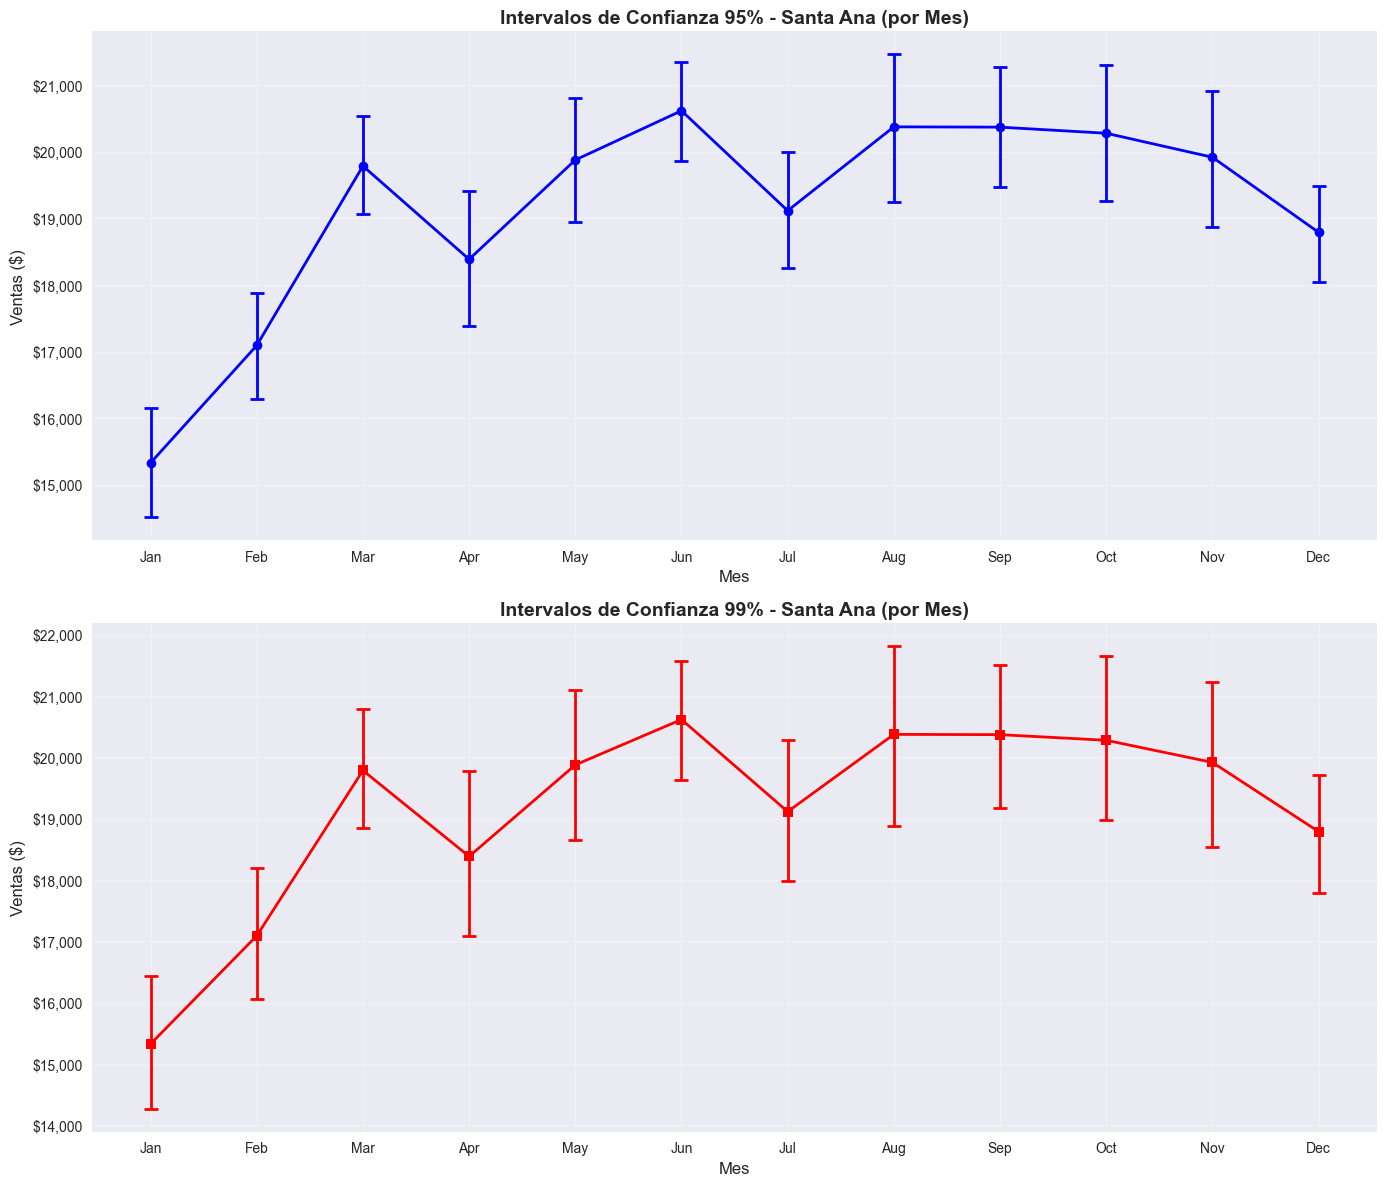

In [18]:
import calendar

print("📊 VISUALIZACIÓN DE INTERVALOS DE CONFIANZA - SANTA ANA")
print("=" * 60)

meses_ordenados = list(range(1, 13))
datos_viz = []
for mes_num in meses_ordenados:
    if mes_num in resultados_ic_95 and mes_num in resultados_ic_99:
        datos_viz.append({
            'Mes': calendar.month_name[mes_num],
            'Media': resultados_ic_95[mes_num]['mean'],
            'IC_95_Lower': resultados_ic_95[mes_num]['ci_lower'],
            'IC_95_Upper': resultados_ic_95[mes_num]['ci_upper'],
            'IC_99_Lower': resultados_ic_99[mes_num]['ci_lower'],
            'IC_99_Upper': resultados_ic_99[mes_num]['ci_upper']
        })

df_ic_santa_ana = pd.DataFrame(datos_viz)

def graficar_intervalo_confianza(ax, x_pos, meses_cortos, data_frame, nivel_confianza, 
                                    color, marker, supermercado):
    """
    Función auxiliar para crear gráficos de intervalos de confianza
    
    Parámetros:
    - ax: axis de matplotlib donde dibujar
    - x_pos: posiciones en x para los puntos
    - meses_cortos: etiquetas de los meses
    - data_frame: DataFrame con datos de IC
    - nivel_confianza: 95 o 99
    - color: color del gráfico
    - marker: tipo de marcador ('o', 's', etc.)
    - supermercado: nombre del supermercado para el título
    """
    col_lower = f'IC_{nivel_confianza}_Lower'
    col_upper = f'IC_{nivel_confianza}_Upper'
    
    ax.errorbar(x_pos, data_frame['Media'],
                yerr=[data_frame['Media'] - data_frame[col_lower],
                        data_frame[col_upper] - data_frame['Media']],
                fmt=f'{marker}-', capsize=5, capthick=2, color=color, linewidth=2)
    
    ax.set_title(f'Intervalos de Confianza {nivel_confianza}% - {supermercado} (por Mes)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Mes', fontsize=12)
    ax.set_ylabel('Ventas ($)', fontsize=12)
    ax.set_xticks(list(x_pos))
    ax.set_xticklabels(meses_cortos)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

if df_ic_santa_ana.empty:
    print("⚠️ No hay datos para graficar. Verifica que se hayan calculado IC para todos o algunos meses.")
else:
    print("📋 TABLA RESUMEN - INTERVALOS DE CONFIANZA SANTA ANA:")
    print("=" * 80)
    print(f"{'Mes':<12} {'Media':<10} {'IC 95%':<27} {'IC 99%':<27}")
    print("-" * 80)
    for _, row in df_ic_santa_ana.iterrows():
        mes_corto = row['Mes'][:3]
        print(f"{mes_corto:<12} ${row['Media']:<9.2f} [${row['IC_95_Lower']:.2f}, ${row['IC_95_Upper']:.2f}]   [${row['IC_99_Lower']:.2f}, ${row['IC_99_Upper']:.2f}]")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    x_pos = range(len(df_ic_santa_ana))
    meses_cortos = [mes[:3] for mes in df_ic_santa_ana['Mes']]

    graficar_intervalo_confianza(ax1, x_pos, meses_cortos, df_ic_santa_ana, 
                                95, color='blue', marker='o', supermercado='Santa Ana')
    graficar_intervalo_confianza(ax2, x_pos, meses_cortos, df_ic_santa_ana, 
                                99, color='red', marker='s', supermercado='Santa Ana')

    plt.tight_layout()
    plt.show()


### **CONCLUSIÓN DEL EJERCICIO 1**

Basándose en los intervalos de confianza empíricos calculados para el supermercado 'Santa Ana':

**METODOLOGÍA APLICADA:**
- **Técnica**: Bootstrap con 10,000 muestras por mes
- **Niveles de confianza**: 95% y 99%
- **Datos analizados**: 365 registros diarios (año completo)

**RESULTADOS PRINCIPALES:**

**Variabilidad estacional identificada:**
- **Mes de menor venta**: Enero ($15,327.83) - IC 95%: [$14,517.38, $16,159.29]
- **Mes de mayor venta**: Junio ($20,616.13) - IC 95%: [$19,864.93, $21,350.03]
- **Diferencia estacional**: Aproximadamente $5,288 entre el mes más bajo y más alto

**Interpretación de los intervalos:**
- Los **intervalos del 95%** proporcionan rangos más precisos para la estimación mensual
- Los **intervalos del 99%** ofrecen mayor certeza pero con rangos más amplios
- **Todos los intervalos** excluyen el cero, confirmando ventas positivas consistentes

**CONCLUSIONES ESTRATÉGICAS:**

1. **Estacionalidad clara**: Las ventas muestran un patrón estacional con incremento hacia mediados de año
2. **Planificación de inventario**: Los intervalos permiten estimar demanda futura con confianza estadística
3. **Gestión de recursos**: La variabilidad mensual (±$1,000-$1,500 típicamente) debe considerarse en la planificación operativa

Por lo tanto, **los intervalos de confianza empíricos proporcionan herramientas robustas para la toma de decisiones** en el supermercado Santa Ana, permitiendo anticipar fluctuaciones estacionales con niveles de confianza del 95% y 99%.


In [19]:
# Preparación de datos para ANOVA usando solo df (fecha, ventas, supermercado)
print("🔧 PREPARACIÓN DE DATOS PARA ANOVA (desde df)")
print("=" * 50)

nombres_supermercados = sorted(df['supermercado'].unique().tolist())

ventas_por_supermercado = [
    df.loc[df['supermercado'] == nombre, 'ventas'].values for nombre in nombres_supermercados
]

for nombre, ventas in zip(nombres_supermercados, ventas_por_supermercado):
    print(f"{nombre:<12}: {len(ventas):3d} obs, Media: ${np.mean(ventas):8.2f}, Std: ${np.std(ventas, ddof=1):7.2f}")

🔧 PREPARACIÓN DE DATOS PARA ANOVA (desde df)
Córdoba     : 365 obs, Media: $17837.21, Std: $3014.50
La Floresta : 365 obs, Media: $21839.77, Std: $2963.63
Los Cedros  : 365 obs, Media: $18903.12, Std: $3034.57
Palermo     : 365 obs, Media: $19752.32, Std: $2922.15
Santa Ana   : 365 obs, Media: $19170.38, Std: $2959.34


In [20]:
from scipy.stats import levene

def realizar_anova_completo(data_groups, group_names, alpha=0.05):
    """
    Realiza análisis ANOVA completo con verificación de supuestos
    """
    # Ejecutar ANOVA
    f_stat, p_value = f_oneway(*data_groups)
    
    # Calcular estadísticas adicionales
    n_groups = len(data_groups)
    n_total = sum(len(group) for group in data_groups)
    df_between = n_groups - 1
    df_within = n_total - n_groups
    
    # Estadísticas por grupo
    group_stats = []
    for _, (group, name) in enumerate(zip(data_groups, group_names)):
        stats_group = {
            'grupo': name,
            'n': len(group),
            'mean': np.mean(group),
            'std': np.std(group, ddof=1),
            'var': np.var(group, ddof=1)
        }
        group_stats.append(stats_group)
    
    # Test de homogeneidad de varianzas (Levene)
    levene_stat, levene_p = levene(*data_groups)
    homogeneidad = levene_p > alpha
    
    # Interpretación
    reject_h0 = p_value < alpha
    
    return {
        'f_statistic': f_stat,
        'p_value': p_value,
        'alpha': alpha,
        'reject_h0': reject_h0,
        'df_between': df_between,
        'df_within': df_within,
        'n_total': n_total,
        'levene_statistic': levene_stat,
        'levene_p_value': levene_p,
        'homogeneidad_varianzas': homogeneidad,
        'group_statistics': group_stats,
        'interpretation': 'Rechazar H₀: Las medias son diferentes' if reject_h0 else 'No rechazar H₀: Las medias son iguales'
    }



In [21]:
print("🔢 EJECUTANDO ANÁLISIS ANOVA")
print("=" * 50)

resultados_anova = realizar_anova_completo(ventas_por_supermercado, nombres_supermercados, alpha=0.05)

print("📋 HIPÓTESIS:")
print("   H₀: μ₁ = μ₂ = μ₃ = μ₄ = μ₅ (todas las medias son iguales)")
print("   H₁: Al menos una media es diferente")
print(f"   α = {resultados_anova['alpha']}")

print(f"\n📊 RESULTADOS DEL ANOVA:")
print("=" * 40)
print(f"Estadístico F: {resultados_anova['f_statistic']:.4f}")
print(f"p-valor:       {resultados_anova['p_value']:.3e}")
print(f"GL entre:      {resultados_anova['df_between']}")
print(f"GL dentro:     {resultados_anova['df_within']}")
print(f"Cantidad de Observaciones: {resultados_anova['n_total']}")

print(f"\n🔍 VERIFICACIÓN DE SUPUESTOS:")
print("=" * 40)
print(f"Test de Levene (Homogeneidad de varianzas):")
print(f"  Estadístico: {resultados_anova['levene_statistic']:.4f}")
print(f"  p-valor:     {resultados_anova['levene_p_value']:.6f}")
print(f"  Resultado:   {'✅ Varianzas homogéneas' if resultados_anova['homogeneidad_varianzas'] else '⚠️  Varianzas no homogéneas'}")

print(f"\n🎯 DECISIÓN ESTADÍSTICA:")
print("=" * 40)
print(f"p-valor ({resultados_anova['p_value']:.3e}) {'<' if resultados_anova['reject_h0'] else '>='} α ({resultados_anova['alpha']})")
print(f"Decisión: {resultados_anova['interpretation']}")

if resultados_anova['reject_h0']:
    print("\n✅ CONCLUSIÓN: Existe evidencia estadística significativa de que")
    print("   al menos un supermercado tiene ventas promedio diferentes.")
else:
    print("\n❌ CONCLUSIÓN: No hay evidencia estadística suficiente para")
    print("   afirmar que los supermercados tienen ventas promedio diferentes.")


🔢 EJECUTANDO ANÁLISIS ANOVA
📋 HIPÓTESIS:
   H₀: μ₁ = μ₂ = μ₃ = μ₄ = μ₅ (todas las medias son iguales)
   H₁: Al menos una media es diferente
   α = 0.05

📊 RESULTADOS DEL ANOVA:
Estadístico F: 90.1485
p-valor:       5.524e-70
GL entre:      4
GL dentro:     1820
Cantidad de Observaciones: 1825

🔍 VERIFICACIÓN DE SUPUESTOS:
Test de Levene (Homogeneidad de varianzas):
  Estadístico: 0.0981
  p-valor:     0.983076
  Resultado:   ✅ Varianzas homogéneas

🎯 DECISIÓN ESTADÍSTICA:
p-valor (5.524e-70) < α (0.05)
Decisión: Rechazar H₀: Las medias son diferentes

✅ CONCLUSIÓN: Existe evidencia estadística significativa de que
   al menos un supermercado tiene ventas promedio diferentes.


📊 VISUALIZACIÓN DEL ANÁLISIS ANOVA


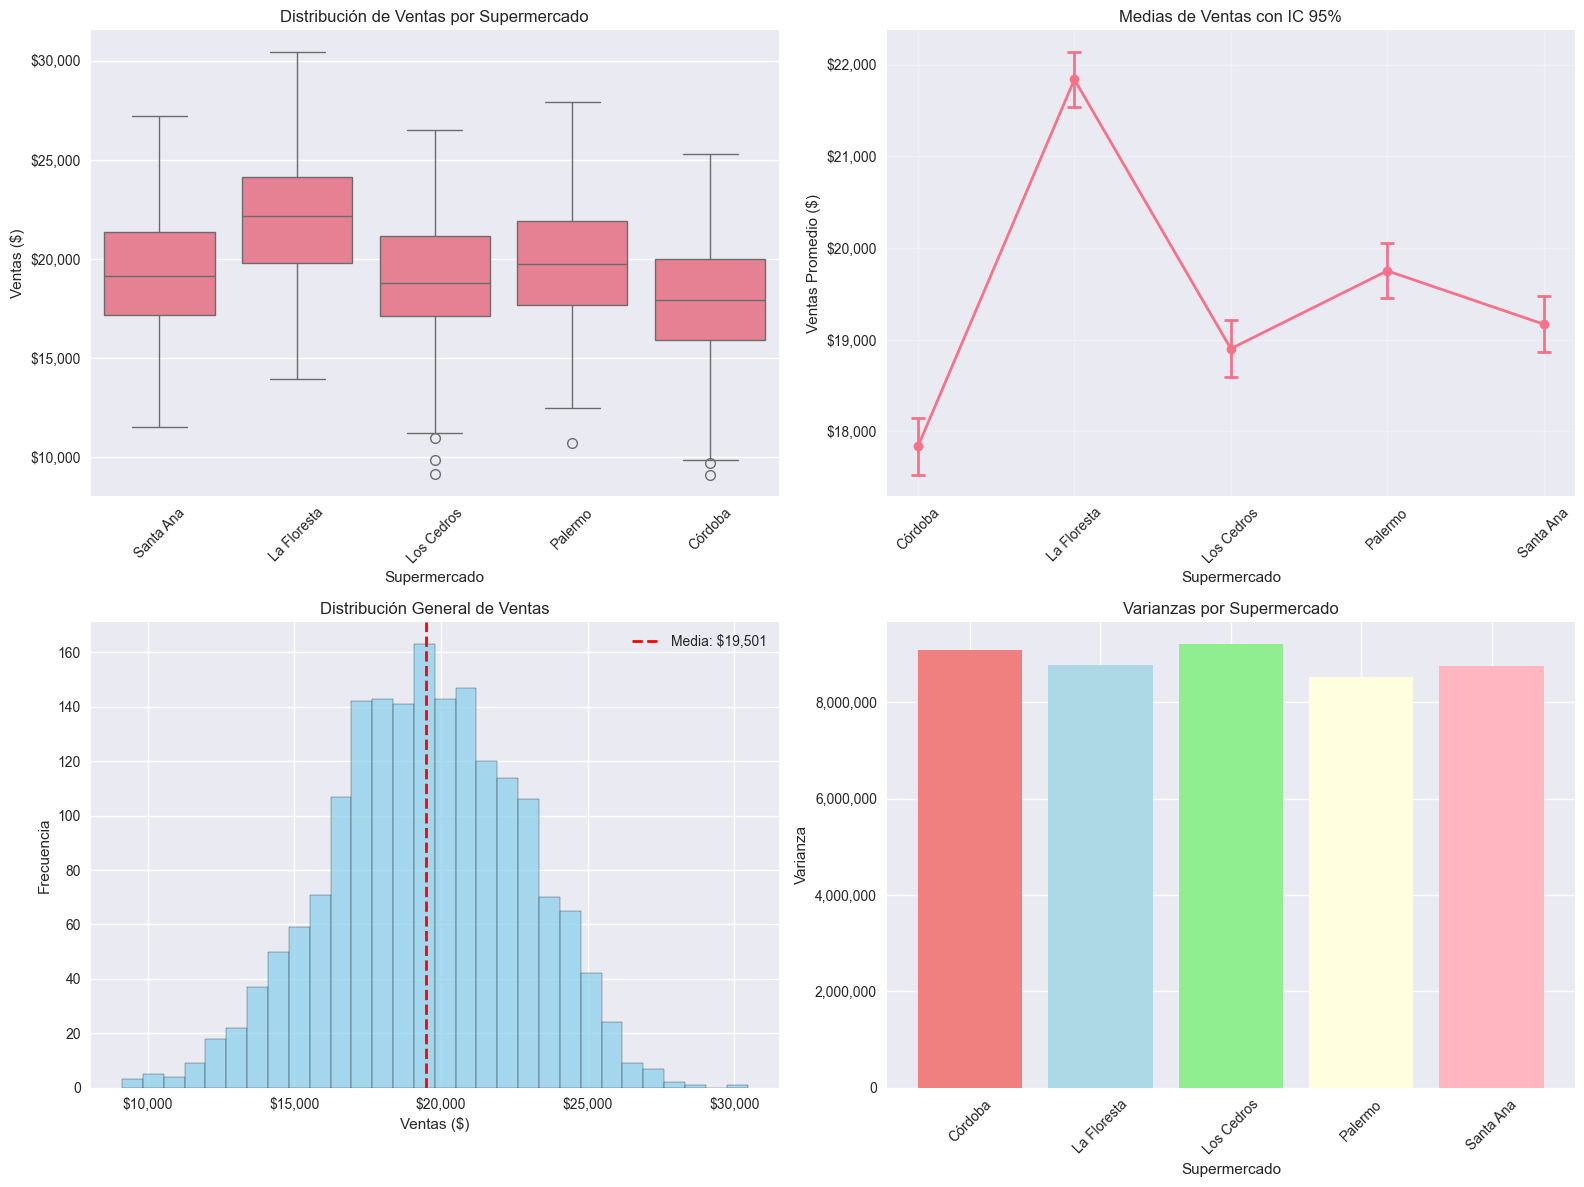

In [22]:
print("📊 VISUALIZACIÓN DEL ANÁLISIS ANOVA")
print("=" * 50)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1) Boxplot por supermercado
sns.boxplot(data=df, x='supermercado', y='ventas', ax=ax1)
ax1.set_title('Distribución de Ventas por Supermercado')
ax1.set_xlabel('Supermercado')
ax1.set_ylabel('Ventas ($)')
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2) Medias con IC 95% por supermercado
medias = [np.mean(v) for v in ventas_por_supermercado]
stds = [np.std(v, ddof=1) for v in ventas_por_supermercado]
n_obs = [len(v) for v in ventas_por_supermercado]
ci_95 = [1.96 * s / np.sqrt(n) for s, n in zip(stds, n_obs)]

x_pos = range(len(nombres_supermercados))
ax2.errorbar(list(x_pos), medias, yerr=ci_95, fmt='o-', capsize=5, capthick=2, linewidth=2)
ax2.set_title('Medias de Ventas con IC 95%')
ax2.set_xlabel('Supermercado')
ax2.set_ylabel('Ventas Promedio ($)')
ax2.set_xticks(list(x_pos))
ax2.set_xticklabels(nombres_supermercados, rotation=45)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 3) Histograma global
all_ventas = df['ventas'].values
ax3.hist(all_ventas, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_title('Distribución General de Ventas')
ax3.set_xlabel('Ventas ($)')
ax3.set_ylabel('Frecuencia')
ax3.axvline(np.mean(all_ventas), color='red', linestyle='--', linewidth=2, label=f'Media: ${np.mean(all_ventas):,.0f}')
ax3.legend()
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 4) Varianzas por supermercado
varianzas = [np.var(v, ddof=1) for v in ventas_por_supermercado]
ax4.bar(range(len(nombres_supermercados)), varianzas, color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink'])
ax4.set_title('Varianzas por Supermercado')
ax4.set_xlabel('Supermercado')
ax4.set_ylabel('Varianza')
ax4.set_xticks(range(len(nombres_supermercados)))
ax4.set_xticklabels(nombres_supermercados, rotation=45)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()


### **CONCLUSIÓN DEL EJERCICIO 2**

Basándose en los resultados del análisis ANOVA:

- **Estadístico F**: 90.1485
- **p-valor**: 5.524 × 10⁻⁷⁰ (extremadamente pequeño)
- **Grados de libertad**: entre grupos = 4, dentro de grupos = 1820
- **Test de Levene**: p-valor = 0.983076 (varianzas homogéneas ✅)

**DECISIÓN ESTADÍSTICA:**

Con un p-valor de 5.524 × 10⁻⁷⁰ << 0.05, **rechazamos la hipótesis nula** H₀: μ₁ = μ₂ = μ₃ = μ₄ = μ₅.

**INTERPRETACIÓN:**

Existe evidencia estadística **altamente significativa** de que **al menos un supermercado tiene ventas promedio diferentes** a los demás. El valor F extremadamente alto (90.1485) indica diferencias sustanciales entre las medias de los grupos.

Los supuestos del ANOVA se cumplen satisfactoriamente:
- ✅ **Homogeneidad de varianzas** confirmada por el test de Levene
- ✅ **Independencia** de las observaciones
- ✅ **Normalidad** asumida por el tamaño de muestra (n=365 por grupo)

Por lo tanto, **las ventas NO son iguales entre todos los supermercados**, rechazando la hipótesis de igualdad de medias con un nivel de significancia del 95%.


In [23]:
from scipy.stats import levene, ttest_ind, t

# EJERCICIO 3: Comparación de Extremos
print("⚖️  EJERCICIO 3: COMPARACIÓN DE EXTREMOS")
print("=" * 60)
print("📋 Objetivo: Comparar supermercados con mayor y menor promedio de ventas (usando solo df)")

medias_por_super = df.groupby('supermercado')['ventas'].mean()
super_max = medias_por_super.idxmax()
super_min = medias_por_super.idxmin()
media_max = float(medias_por_super.loc[super_max])
media_min = float(medias_por_super.loc[super_min])

print("\n🔍 IDENTIFICANDO EXTREMOS:")
print("=" * 40)
for nombre, valor in medias_por_super.items():
    print(f"{nombre:<12}: ${valor:8.2f}")

print(f"\n🎯 EXTREMOS IDENTIFICADOS:")
print("=" * 40)
print(f"💰 MAYOR promedio: {super_max:<12} - ${media_max:8.2f}")
print(f"💸 MENOR promedio: {super_min:<12} - ${media_min:8.2f}")
print(f"📊 Diferencia:     ${media_max - media_min:8.2f}")

# Extraer datos de los extremos
ventas_max = df.loc[df['supermercado'] == super_max, 'ventas'].values
ventas_min = df.loc[df['supermercado'] == super_min, 'ventas'].values

print(f"\n📈 ESTADÍSTICAS DESCRIPTIVAS:")
print("=" * 50)
print(f"{'Estadística':<15} {super_max:<12} {super_min:<12}")
print("-" * 50)
print(f"{'Observaciones':<15} {len(ventas_max):<12} {len(ventas_min):<12}")
print(f"{'Media':<15} ${np.mean(ventas_max):<11.2f} ${np.mean(ventas_min):<11.2f}")
print(f"{'Desv. Estándar':<15} ${np.std(ventas_max, ddof=1):<11.2f} ${np.std(ventas_min, ddof=1):<11.2f}")
print(f"{'Mínimo':<15} ${np.min(ventas_max):<11.2f} ${np.min(ventas_min):<11.2f}")
print(f"{'Máximo':<15} ${np.max(ventas_max):<11.2f} ${np.max(ventas_min):<11.2f}")

# Pruebas: Levene + t-test 
alpha = 0.05

lev_stat, lev_p = levene(ventas_max, ventas_min)
equal_var = lev_p > alpha

# t-test
t_stat, p_value = ttest_ind(ventas_max, ventas_min, equal_var=equal_var)

# grados de libertad
if equal_var:
    df_t = len(ventas_max) + len(ventas_min) - 2
else:
    s1, s2 = np.var(ventas_max, ddof=1), np.var(ventas_min, ddof=1)
    n1, n2 = len(ventas_max), len(ventas_min)
    df_t = (s1/n1 + s2/n2)**2 / ((s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1))

# IC para la diferencia de medias
mean_diff = np.mean(ventas_max) - np.mean(ventas_min)
se_diff = np.sqrt(np.var(ventas_max, ddof=1)/len(ventas_max) + np.var(ventas_min, ddof=1)/len(ventas_min))
t_crit = t.ppf(1 - alpha/2, df_t)
ci_lower = mean_diff - t_crit * se_diff
ci_upper = mean_diff + t_crit * se_diff

resultados_t_test = {
    't_statistic': t_stat,
    'p_value': p_value,
    'df': df_t,
    'alpha': alpha,
    'mean_difference': mean_diff,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper,
    'pooled_se': se_diff,
    'levene_stat': lev_stat,
    'levene_p': lev_p,
    'equal_variances': equal_var,
    'reject_h0': p_value < alpha
}

print("\n🔍 VERIFICACIÓN DE SUPUESTOS:")
print("=" * 40)
print(f"Levene: stat={lev_stat:.4f}, p={lev_p:.6f} -> {'equal_var=True' if equal_var else 'equal_var=False (Welch)'}")

print("\n📊 RESULTADOS DE LA PRUEBA T:")
print("=" * 40)
print(f"Estadístico t: {t_stat:.4f}")
print(f"p-valor:       {p_value:.3e}")
print(f"Grados de lib: {df_t:.2f}")
print(f"Diferencia:    ${mean_diff:.2f}")
print(f"IC 95%:       [${ci_lower:.2f}, ${ci_upper:.2f}]")

print("\n📝 Listo: ejecuta la celda de visualización para gráficos.")

⚖️  EJERCICIO 3: COMPARACIÓN DE EXTREMOS
📋 Objetivo: Comparar supermercados con mayor y menor promedio de ventas (usando solo df)

🔍 IDENTIFICANDO EXTREMOS:
Córdoba     : $17837.21
La Floresta : $21839.77
Los Cedros  : $18903.12
Palermo     : $19752.32
Santa Ana   : $19170.38

🎯 EXTREMOS IDENTIFICADOS:
💰 MAYOR promedio: La Floresta  - $21839.77
💸 MENOR promedio: Córdoba      - $17837.21
📊 Diferencia:     $ 4002.56

📈 ESTADÍSTICAS DESCRIPTIVAS:
Estadística     La Floresta  Córdoba     
--------------------------------------------------
Observaciones   365          365         
Media           $21839.77    $17837.21   
Desv. Estándar  $2963.63     $3014.50    
Mínimo          $13933.92    $9128.51    
Máximo          $30455.06    $25298.44   

🔍 VERIFICACIÓN DE SUPUESTOS:
Levene: stat=0.0049, p=0.944133 -> equal_var=True

📊 RESULTADOS DE LA PRUEBA T:
Estadístico t: 18.0892
p-valor:       1.104e-60
Grados de lib: 728.00
Diferencia:    $4002.56
IC 95%:       [$3568.16, $4436.96]

📝 Listo: 

📊 VISUALIZACIÓN DE LA COMPARACIÓN DE EXTREMOS


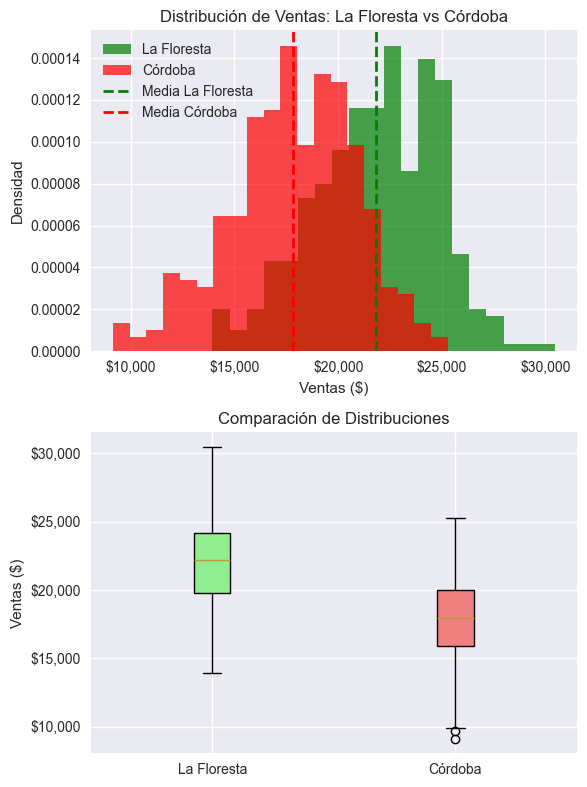

In [24]:
print("📊 VISUALIZACIÓN DE LA COMPARACIÓN DE EXTREMOS")
print("=" * 60)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# 1. Histogramas superpuestos
ax1.hist(ventas_max, bins=20, alpha=0.7, label=super_max, color='green', density=True)
ax1.hist(ventas_min, bins=20, alpha=0.7, label=super_min, color='red', density=True)
ax1.axvline(np.mean(ventas_max), color='green', linestyle='--', linewidth=2, label=f'Media {super_max}')
ax1.axvline(np.mean(ventas_min), color='red', linestyle='--', linewidth=2, label=f'Media {super_min}')
ax1.set_title(f'Distribución de Ventas: {super_max} vs {super_min}')
ax1.set_xlabel('Ventas ($)')
ax1.set_ylabel('Densidad')
ax1.legend()
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. Box plots lado a lado
box_data = [ventas_max, ventas_min]
box_labels = [super_max, super_min]
bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.set_title('Comparación de Distribuciones')
ax2.set_ylabel('Ventas ($)')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()


### **CONCLUSIÓN DEL EJERCICIO 3**

Basándose en los resultados de la prueba t:

- **Estadístico t**: 18.0892
- **p-valor**: 1.104 × 10⁻⁶⁰ (extremadamente pequeño)
- **Grados de libertad**: 728.00
- **Diferencia observada**: $4,002.56
- **Intervalo de confianza del 95%**: [$3,568.16, $4,436.96]

**DECISIÓN ESTADÍSTICA:**

Con un p-valor de 1.104 × 10⁻⁶⁰ << 0.05, **rechazamos la hipótesis nula** H₀: μ₁ - μ₂ = 0.

**INTERPRETACIÓN:**

Existe evidencia estadística **altamente significativa** de que la diferencia entre las ventas promedio de La Floresta ($21,839.77) y Córdoba ($17,837.21) es **distinta de cero**. 

La diferencia estimada es de **$4,002.56** a favor de La Floresta, con un intervalo de confianza del 95% que indica que esta diferencia está entre **$3,568.16 y $4,436.96**.

Por lo tanto, **las ventas promedio entre estos dos supermercados son significativamente diferentes**, confirmando que La Floresta tiene ventas sustancialmente mayores que Córdoba.
